# Earth Mover's Distance visualizations

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Setting probability distributions

P_r:


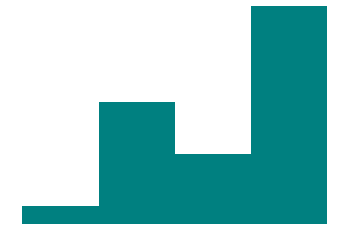

P_t:


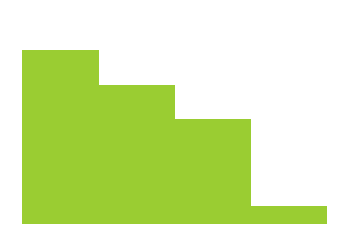

In [2]:
l = 4 # number of support elements 

# define distributions 
P_r = np.array([1, 7, 4, 13])
P_t = np.array([10, 8, 6, 1])
# normalize to get probability distributions
P_r = P_r / np.sum(P_r)
P_t = P_t / np.sum(P_t)

# plot & save distributions
plt.bar(range(l), P_r, 1, color='teal', alpha=1)
plt.axis('off')
plt.ylim(0, 0.5)
# plt.savefig("discrete_p_r.svg") # uncomment to save svg image
print("P_r:")
plt.show()

plt.bar(range(l), P_t, 1, color='yellowgreen', alpha=1)
plt.axis('off')
plt.ylim(0, 0.5)
# plt.savefig("discrete_p_t.svg")
print("P_t:")
plt.show()

### Define matrices

In [3]:
# define distances matrix D
D = np.ndarray(shape=(l, l))

for i in range(l):
    for j in range(l):
        D[i,j] = abs(range(l)[i] - range(l)[j])
        
print(D) # each diagonal entry is zero

[[0. 1. 2. 3.]
 [1. 0. 1. 2.]
 [2. 1. 0. 1.]
 [3. 2. 1. 0.]]


The optimal transport plan can be determined using the generic method of Linear Programming: find a vector $\mathbf{x}$ (that is the flattening of the transport plan gamma) that minimizes $\mathbf{c}^\top\mathbf{x}$ with the constraints $\mathbf{Ax}=\mathbf{b}$ and $\mathbf{x} \geq \mathbf{0}$. 

The vector $\mathbf{c}$ is the flattened version of the distance matrix $\mathbf{D}$.  

$\mathbf{b} =\,[$ `P_r,P_t` $ ]^\top$ is the vector formed by concatenating `P_r` and `P_t`.

![immagine.png](img.png)

In [4]:
# deifne matrix A as the join of two matrices 
# A is such that Ax equals the distributions vector  
A_r = np.zeros((l, l, l))
A_t = np.zeros((l, l, l))

for i in range(l):
    for j in range(l):
        A_r[i, i, j] = 1
        A_t[i, j, i] = 1

print(A_r, "\n") # example
        
A = np.concatenate((A_r.reshape((l, l**2)), A_t.reshape((l, l**2))), axis=0)
print("A: \n", A, "\n")


[[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]]] 

A: 
 [[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]] 



In [5]:
# define b as concatenation of distributions P_r and P_t
b = np.concatenate((P_r, P_t), axis=0)

# c is obtained flattening the matrix D
c = D.reshape((l**2))

c

array([0., 1., 2., 3., 1., 0., 1., 2., 2., 1., 0., 1., 3., 2., 1., 0.])

### Solving the optimal mass moving problem

In [6]:
# find EM distance by solving a linear programming problem
from scipy.optimize import linprog

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
# minimize a linear objective function subject to linear equality and inequality constraints.
opt_res = linprog(c, A_eq=A, b_eq=b, bounds=[0, None])

In [7]:
opt_res.keys()

dict_keys(['x', 'fun', 'slack', 'con', 'status', 'message', 'nit', 'success'])

In [8]:
# "fun" returns the optimal minimum value (the EM distance)
emd = opt_res.fun

print("EM distance:", emd, "\n")


EM distance: 1.2400000000070897 



### Displaying results

Gamma:


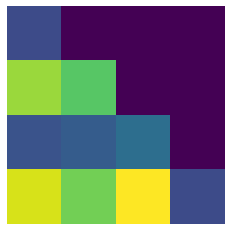

D:


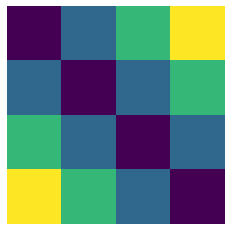

In [9]:
from matplotlib import cm

# gamma provides the optimal transport plan (optimal joint distribution)
gamma = opt_res.x.reshape((l, l))

# show gamma (optimal joint distribution) and D (distances matrix)
plt.imshow(gamma, cmap=cm.viridis, interpolation='nearest')
plt.axis('off')
# plt.savefig("transport_plan.svg") 
print("Gamma:")
plt.show()

plt.imshow(D, cmap=cm.viridis, interpolation='nearest')
plt.axis('off')
# plt.savefig("distances.svg")
print("D:")
plt.show()

### Plotting the mass moved

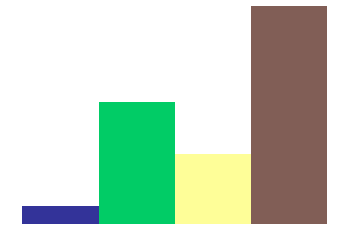

In [10]:
import matplotlib.colors as colors

r = range(l)
cNorm = colors.Normalize(vmin=0, vmax=l)
colorMap = cm.ScalarMappable(norm=cNorm, cmap=cm.terrain)

current_bottom = np.zeros(l)

for i in r.__reversed__():
    plt.bar(r, gamma[r, i], 1, color=colorMap.to_rgba(r), bottom=current_bottom)
    current_bottom = current_bottom + gamma[r, i]

plt.axis('off')
plt.ylim(0, 0.5)
# plt.savefig("earth_move_p_r.svg")
plt.show()

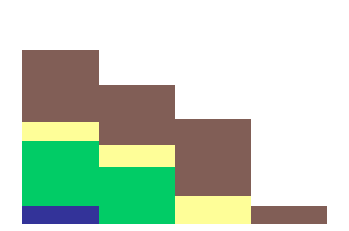

In [11]:
# plot the P_t distribution highlighting the mass moved from P_r 
current_bottom = np.zeros(l)
r = range(l)

for i in r:
    plt.bar(r, gamma[i, r], 1, color=colorMap.to_rgba(i), bottom=current_bottom)
    current_bottom = current_bottom + gamma[i, r]

plt.axis('off')
plt.ylim(0, 0.5)
# plt.savefig("earth_move_p_t.svg")
plt.show()